In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [6]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.logit_graph as lg
import src.logit_graph.logit_estimator as estimator
import src.logit_graph.utils as utils
import src.logit_graph.model_selection as model_selection
import src.logit_graph.gic as gic
import src.logit_graph.param_estimator as pe
import src.logit_graph.graph as graph
import src.logit_graph.model_selection as ms

from src.logit_graph.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [7]:
def load_connectome_graphs(data_dir):
    """
    Loads all graphml files from the specified connectomes directory.

    Args:
        data_dir (str): The directory containing the connectome graphml files.

    Returns:
        list: List of loaded networkx Graph objects
        dict: Dictionary mapping graphs to their filepaths
    """
    graphs = []
    graph_filepaths = {}
    
    # Get all graphml files in directory
    graphml_files = [f for f in os.listdir(data_dir) if f.endswith('.graphml')]
    
    for filename in graphml_files:
        filepath = os.path.join(data_dir, filename)
        try:
            # Load the graphml file
            graph = nx.read_graphml(filepath)
            graphs.append(graph) 
            graph_filepaths[graph] = filepath
            print(f"Graph {filename} loaded successfully. Edges: {graph.number_of_edges()}, Nodes: {graph.number_of_nodes()}")
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            
    return graphs, graph_filepaths

data_directory = '../../data/connectomes'
graphs, graph_filepaths = load_connectome_graphs(data_directory)


Graph p.pacificus_neural.synaptic_2.graphml loaded successfully. Edges: 611, Nodes: 50
Graph rhesus_cerebral.cortex_1.graphml loaded successfully. Edges: 1989, Nodes: 91
Graph rattus.norvegicus_brain_1.graphml loaded successfully. Edges: 27667, Nodes: 503
Graph mixed.species_brain_1.graphml loaded successfully. Edges: 1139, Nodes: 65
Graph mouse_visual.cortex_2.graphml loaded successfully. Edges: 214, Nodes: 195
Graph rattus.norvegicus_brain_2.graphml loaded successfully. Edges: 30088, Nodes: 503
Graph p.pacificus_neural.synaptic_1.graphml loaded successfully. Edges: 511, Nodes: 54
Graph mouse_visual.cortex_1.graphml loaded successfully. Edges: 44, Nodes: 29
Graph rattus.norvegicus_brain_3.graphml loaded successfully. Edges: 33020, Nodes: 496
Graph rhesus_interareal.cortical.network_2.graphml loaded successfully. Edges: 2667, Nodes: 93
Graph rhesus_brain_1.graphml loaded successfully. Edges: 4090, Nodes: 242
Graph mouse_retina_1.graphml loaded successfully. Edges: 577350, Nodes: 1123
G

### Fitting single graph

Loading the different graphs into a networkx graph

In [ ]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[0]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
fitter_params = {
    "d": 0,
    "n_iteration": 8000,
    "patience": 100,
    "verbose": True
}

# Initialize the fitter with the parameters

lg_fitter = LogitGraphFitter(**fitter_params)
lg_fitter.fit(target_graph)



==================== Processing Graph ====================
Original graph - Nodes: 333, Edges: 2519
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 10.6155 (Target: ≤5) 📈 Best Spectrum Diff: 397.3235 ⏱️  Patience: 0/100 🔗 Edges: 13 (Target: 2519)
📊 Iteration 2,000: 🎯 GIC (KL): 9.9305 (Target: ≤5) 📈 Best Spectrum Diff: 395.2793 ⏱️  Patience: 0/100 🔗 Edges: 20 (Target: 2519)
📊 Iteration 3,000: 🎯 GIC (KL): 7.7881 (Target: ≤5) 📈 Best Spectrum Diff: 391.4877 ⏱️  Patience: 0/100 🔗 Edges: 35 (Target: 2519)
🎉 GIC threshold 5 reached at iteration 3,738 (GIC: 1.8970)
🔍 Starting convergence check based on spectrum difference (Patience: 100)
📊 Iteration 4,000: 🎯 GIC (KL): 1.8970 (Target: ≤5) 📈 Best Spectrum Diff: 386.1470 ⏱️  Patience: 4/100 🔗 Edges: 56 (Target: 2519)
📊 Iteration 5,000: 🎯 GIC (KL): 1.8970 (Target: ≤5) 📈 Best Spectrum Diff: 375.2692 ⏱️  Patience: 0/100 🔗 Edges: 104 (Target: 2519)
📊 Iteration 6,000: 🎯 GIC (KL): 1.8970 (Target: ≤5) 📈 Best Spectrum Diff: 354.0893 ⏱️  Patience: 5/100 🔗 Edges: 208 (Target: 2519)
📊 Iteration 7,000: 🎯 GIC (KL): 1.8970 (Target: ≤5) 📈 Best Spectrum Diff: 317.1933 ⏱️  Pati

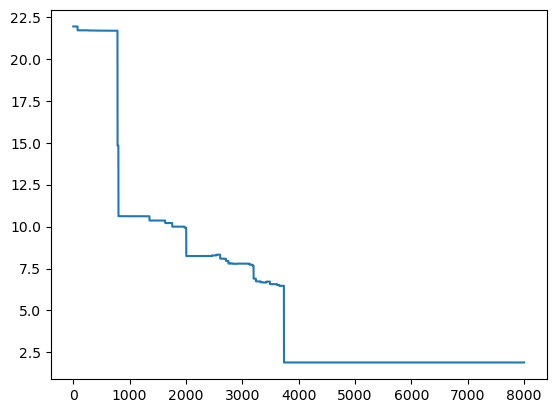

In [28]:
# Log the gic also with the spectrum digg and edges
plt.plot(lg_fitter.metadata['gic_values'])

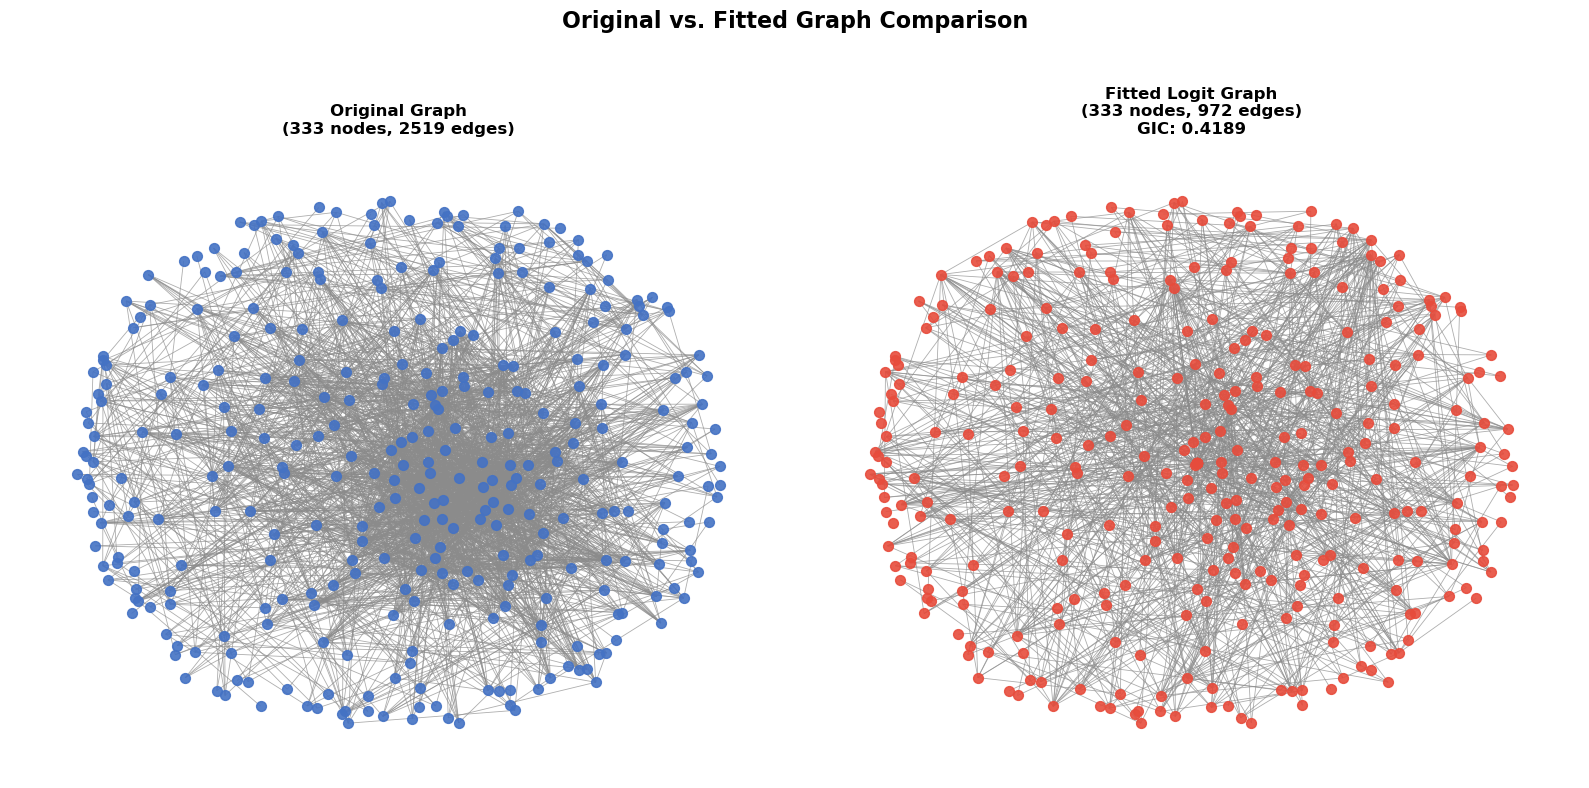

In [29]:

def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    pos = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Ensure the position dictionary is compatible with the fitted graph
        pos_fitted = {node: pos.get(node, (0, 0)) for node in fitted_graph.nodes}
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if lg_fitter.metadata['fit_success']:
    comparison_figure = compare_graphs_visually(target_graph, lg_fitter.fitted_graph, lg_fitter.metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


### Comparison other models

comparing multiple models

In [16]:
# Get list of connectome files
graph_files = []
connectome_dir = '../../data/connectomes/'
for file in os.listdir(connectome_dir):
    if file.endswith('.graphml'):
        graph_files.append(os.path.join(connectome_dir, file))

# Sort by number of nodes
graph_files = sorted(graph_files, key=lambda file: nx.read_graphml(file).number_of_nodes())


In [18]:
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.3},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 1, 'hi': 6},     # BA (m)
    ],
    "verbose": True,
}

In [19]:
graph_files

['../../data/connectomes/mouse_visual.cortex_1.graphml',
 '../../data/connectomes/p.pacificus_neural.synaptic_2.graphml',
 '../../data/connectomes/p.pacificus_neural.synaptic_1.graphml',
 '../../data/connectomes/mixed.species_brain_1.graphml',
 '../../data/connectomes/rhesus_cerebral.cortex_1.graphml',
 '../../data/connectomes/rhesus_brain_2.graphml',
 '../../data/connectomes/rhesus_interareal.cortical.network_2.graphml',
 '../../data/connectomes/mouse_visual.cortex_2.graphml',
 '../../data/connectomes/mouse_brain_1.graphml',
 '../../data/connectomes/rhesus_brain_1.graphml',
 '../../data/connectomes/c.elegans_neural.male_1.graphml',
 '../../data/connectomes/c.elegans.herm_pharynx_1.graphml',
 '../../data/connectomes/rattus.norvegicus_brain_3.graphml',
 '../../data/connectomes/rattus.norvegicus_brain_1.graphml',
 '../../data/connectomes/rattus.norvegicus_brain_2.graphml',
 '../../data/connectomes/kasthuri_graph_v4.graphml',
 '../../data/connectomes/mouse_retina_1.graphml',
 '../../data/

In [21]:
comparators = []
folder_name = 'runs/fitted_graphs_comparison_connectomes4'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    if 'rhesus_cerebral.cortex_1' in graph_file:
        print(f"Loading graph from: {graph_file}")


        original_graph = nx.read_graphml(graph_file)
        # convert to undirected
        original_graph = original_graph.to_undirected()

        if original_graph.number_of_nodes() <= 100:
            n_iteration = 4000
        elif original_graph.number_of_nodes() > 100 and original_graph.number_of_nodes() <= 300:
            n_iteration = 8000
        elif original_graph.number_of_nodes() > 300 and original_graph.number_of_nodes() <= 500:
            n_iteration = 12000
        elif original_graph.number_of_nodes() > 700:
            n_iteration = 20000
        else:
            pass
        sim_params['lg_params']['max_iterations'] = n_iteration

        # Run the comparison
        comparator = GraphModelComparator(**sim_params)
        comparator.compare(original_graph, graph_file)
        comparators.append(comparator)

        import pickle
        graph_name = graph_file.split('/')[-1].split('.')[0]
        # graph_name = graph_file
        with open(f'{folder_name}/comparators_{graph_name}.pkl', 'wb') as f:
            pickle.dump(comparators, f)



Loading graph from: ../../data/connectomes/rhesus_cerebral.cortex_1.graphml

============================== Processing Graph: rhesus_cerebral.cortex_1.graphml ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8381 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.4960 ⏱️  Patience: 0/10 🔗 Edges: 1076 (Target: 1771)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4381 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.6089 ⏱️  Patience: 0/10 🔗 Edges: 1724 (Target: 1771)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6367
   📈 Results Summary
   🏆 Best iteration found: 2,119
   📊 Best spectrum difference: 279.4572
   🔗 Edges in best graph: 1790 (Real graph edges: 1771)
d=0: GIC=0.4367, sigma=-3.9681
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6692 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.5657 ⏱️  Patience: 0/10 🔗 Edges: 1052 (Target: 1771)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4416 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.9662 ⏱️  Patience: 0/10 🔗 Edges: 1697 (Target: 1771)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6394
   📈 Results Summary
   🏆 Best iteration found: 2,211
   📊 Best spectrum difference: 274.9669
   🔗 Edges in best graph: 1810 (Real graph edges: 1771)
d=1: GIC=0.4290, sigma=-6.6334
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8812 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.0380 ⏱️  Patience: 0/10 🔗 Edges: 1072 (Target: 1771)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6445 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.8344 ⏱️  Patience: 0/10 🔗 Edges: 1743 (Target: 1771)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6362
   📈 Results Summary
   🏆 Best iteration found: 2,134
   📊 Best spectrum difference: 278.6900
   🔗 Edges in best graph: 1817 (Real graph edges: 1771)
d=2: GIC=0.4255, sigma=-17.2625
Best LG fit found with GIC: 0.4255

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5893173737446438
Testing the selected model for WS
WS gic: 1.6457754842143246
Testing the selected model for BA
BA gic: 0.7816156110509775
ER fitting - GIC: 0.5893, Param: 0.3000
BA fitting - GIC: 0.7816, Param: 1.5000
WS fitting - GIC: 1.6458, Param: 20.2000

--- Calculating graph a